In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import umap
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    accuracy_score,
    roc_auc_score,
)


In [10]:
data = pd.read_csv("./Soil Nutrients.csv")
categorical_cols = data.select_dtypes(include=["object"]).columns
numerical_cols = data.select_dtypes(include=["float64"]).columns

print("Categorical Columns:", list(categorical_cols))
print("Numerical Columns:", list(numerical_cols))

Categorical Columns: ['Name', 'Fertility', 'Photoperiod', 'Category_pH', 'Soil_Type', 'Season']
Numerical Columns: ['Temperature', 'Rainfall', 'pH', 'Light_Hours', 'Light_Intensity', 'Rh', 'Nitrogen', 'Phosphorus', 'Potassium', 'Yield', 'N_Ratio', 'P_Ratio', 'K_Ratio']


In [11]:
label_encoder = LabelEncoder()
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

data.head()

,Name,Fertility,Photoperiod,Temperature,Rainfall,pH,Light_Hours,Light_Intensity,Rh,Nitrogen,Phosphorus,Potassium,Yield,Category_pH,Soil_Type,Season,N_Ratio,P_Ratio,K_Ratio
0,19,1,0,20.887923,747.860765,6.571548,13.091483,533.762876,91.197196,170.800381,118.670058,243.331211,20.369555,0,0,2,10.0,10.0,10.0
1,19,1,0,18.062721,711.104329,6.251806,13.063016,505.789101,91.939623,179.290364,121.020244,246.910378,20.402751,0,0,1,10.0,10.0,10.0
2,19,1,2,16.776782,774.038247,6.346916,12.945927,512.985617,91.387286,181.440732,116.936806,242.699601,19.158847,0,0,2,10.0,10.0,10.0
3,19,1,2,14.281000,665.633506,6.259598,13.318922,484.860067,91.254598,176.165282,122.233153,237.096892,20.265745,0,0,2,10.0,10.0,10.0
4,19,1,0,21.444490,806.531455,6.384368,13.312915,512.747307,92.354829,182.935334,126.088234,243.880364,20.397336,0,0,1,10.0,10.0,10.0


In [12]:
y = data["Category_pH"]
X = data.drop(columns=["Category_pH", "pH"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

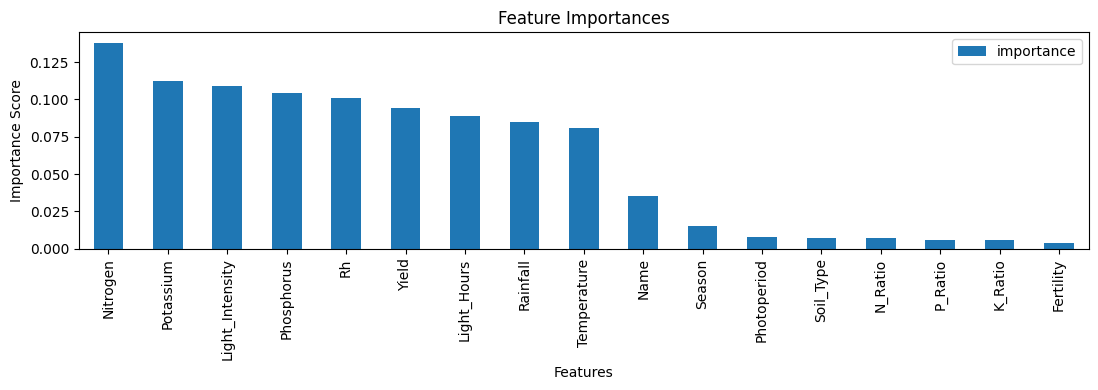

In [13]:
rfc = RandomForestClassifier()

# fit random forest classifier on the training set
rfc.fit(X_train, y_train)
# extract important features
score = np.round(rfc.feature_importances_, 3)
importances = pd.DataFrame({"feature": X_train.columns, "importance": score})
importances = importances.sort_values("importance", ascending=False).set_index("feature")
# plot importances
plt.rcParams["figure.figsize"] = (11, 4)
importances.plot.bar()
plt.title("Feature Importances")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

In [14]:
# Drop the features with importance less than 0.05
threshold = 0.05
important_features = importances[importances["importance"] >= threshold].index
print("Important Features:", important_features)
# Select only the important features for training and testing
X_train_important = X_train[important_features]
X_test_important = X_test[important_features]

Important Features: Index(['Nitrogen', 'Potassium', 'Light_Intensity', 'Phosphorus', 'Rh', 'Yield',
       'Light_Hours', 'Rainfall', 'Temperature'],
      dtype='object', name='feature')


In [15]:
# Standardize the features
scaler = StandardScaler()
X_train_important = scaler.fit_transform(X_train_important)
X_test_important = scaler.transform(X_test_important)
# Handle class imbalance
# ros = RandomOverSampler(random_state=42)
# X_train_important, y_train = ros.fit_resample(X_train_important, y_train)


Classifier Performance:
                     accuracy  precision    recall        f1   roc_auc
XGBoost              0.648377   0.647246  0.648377  0.647525  0.832758
Gradient Boosting    0.648701   0.639506  0.648701  0.643143  0.840722
Random Forest        0.641558   0.638874  0.641558  0.640138  0.835235
SVM                  0.642532   0.634454  0.642532  0.636608  0.827889
KNN                  0.624026   0.622522  0.624026  0.623214  0.799434
Logistic Regression  0.634416   0.600915  0.634416  0.608276  0.811221


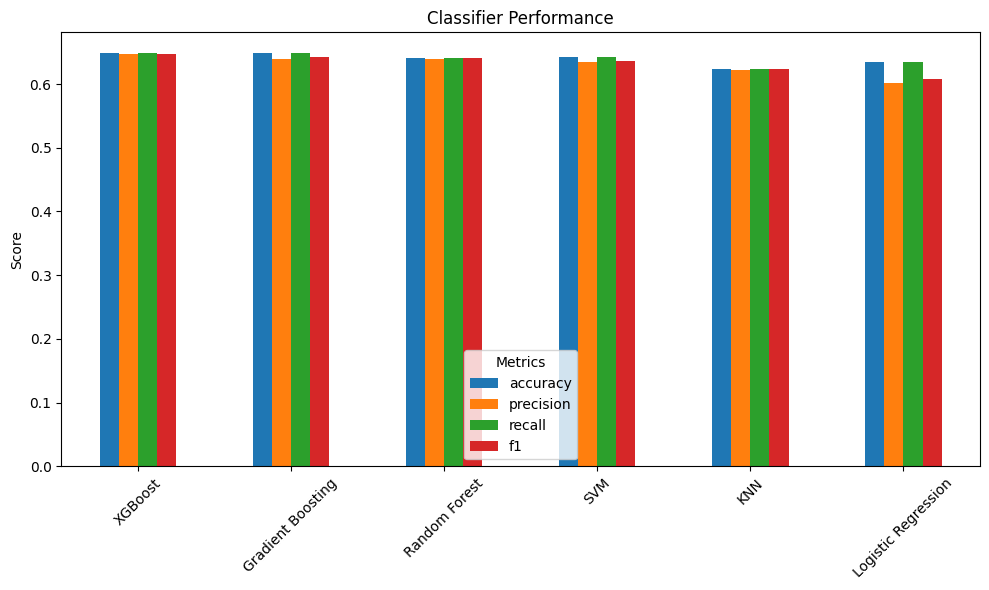

In [16]:
# Define the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric="logloss"),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
}

# Train and evaluate each classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train_important, y_train)
    y_pred = clf.predict(X_test_important)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1": f1_score(y_test, y_pred, average="weighted"),
        "roc_auc": roc_auc_score(y_test, clf.predict_proba(X_test_important), multi_class="ovr"),
    }
# Print the results
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="f1", ascending=False)
print("\nClassifier Performance:")
print(results_df)
# Plot the results
plt.figure(figsize=(10, 6))
results_df[["accuracy", "precision", "recall", "f1"]].plot(kind="bar", ax=plt.gca())
plt.title("Classifier Performance")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.tight_layout()